In [ ]:
# brain_tumor_mobilenet_colab.py


import os
import tensorflow as tf

# 0. Enable XLA (JIT) and mixed precision
tf.config.optimizer.set_jit(True)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# 1. Correct imports for MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# 0. Enable XLA (JIT) and mixed precision for max throughput
tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. Configuration
DATA_DIR      = '/content/drive/MyDrive/Brain Tumor/Dataset/Training'
IMG_SIZE      = (224, 224)
BATCH_SIZE    = 64    # increased from 32
EPOCHS         = 10
LR             = 1e-4
AUTOTUNE       = tf.data.AUTOTUNE

# 3. Build tf.data pipeline
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

def prep(image, label):
    return preprocess_input(image), label

train_ds = (train_ds
            .map(prep, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(2000)
            .prefetch(AUTOTUNE))
val_ds = (val_ds
          .map(prep, num_parallel_calls=AUTOTUNE)
          .cache()
          .prefetch(AUTOTUNE))

# 4. Build model on MobileNetV2
base = MobileNetV2(
    input_shape=(*IMG_SIZE,3),
    include_top=False,
    weights='imagenet',
    alpha=1.0   # full width; reduce (0.75,0.5) for even smaller
)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
# Mixed precision: force float32 on output
output = Dense(1, activation='sigmoid', dtype='float32')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(
    optimizer=Adam(LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 5. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# 6. Save
model.save('/content/brain_tumor_mobilenet.h5')

# 7. Inference helper
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(path):
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img)
    arr = preprocess_input(arr)
    arr = tf.expand_dims(arr, 0)
    prob = model.predict(arr)[0][0]
    return ('Tumor Present', prob) if prob>0.5 else ('No Tumor', prob)

# Example Test
if __name__=="__main__":
    test_path = '/content/drive/MyDrive/Brain Tumor/Dataset/Testing/No/Copy of Te-no_0348.jpg'
    print(predict_image(test_path))


Mounted at /content/drive
Found 5712 files belonging to 2 classes.
Using 4570 files for training.
Found 5712 files belonging to 2 classes.
Using 1142 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1847s 18s/step - accuracy: 0.7951 - loss: 0.4329 - val_accuracy: 0.9650 - val_loss: 0.1246
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1280s 17s/step - accuracy: 0.9598 - loss: 0.1303 - val_accuracy: 0.9711 - val_loss: 0.0975
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1260s 17s/step - accuracy: 0.9670 - loss: 0.0989 - val_accuracy: 0.9711 - val_loss: 0.0841
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1214s 17s/step - accuracy: 0.9711 - loss: 0.0830 - val_accuracy: 0.9772 - val_loss: 0.0759
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1178s 16s/step - accuracy: 0.9768 - loss: 0.0722 - val_accuracy: 0.9772 - val_loss: 0.0703
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1202s 17s/step - accuracy: 0.9828 - loss: 0.0596 - val_accuracy: 0.9816 - val_loss: 0.0663
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1151s 16s/step - accuracy: 0.9829 - loss: 0.0513 - val_accuracy: 0.9825 - val_loss: 0.0650
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1207s 17s/step - accuracy: 0.9854 - loss: 0.0462 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
('No Tumor', np.float32(0.03371977))


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# make a folder if needed
!mkdir -p "/content/drive/MyDrive/Brain Tumor"

# save in the persistent Drive folder
model.save('/content/drive/MyDrive/Brain Tumor/brain_tumor_mobilenet.h5',
           include_optimizer=False)

print("✓ Saved to Drive!")


Mounted at /content/drive


✓ Saved to Drive!


In [ ]:

MODEL_PATH = '/content/drive/MyDrive/Brain Tumor/brain_tumor_mobilenet.h5'


In [ ]:
from pathlib import Path
assert Path(MODEL_PATH).exists(), "Model file not found—double-check the path!"
print("✓ Model located at", MODEL_PATH)

✓ Model located at /content/drive/MyDrive/Brain Tumor/brain_tumor_mobilenet.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from pathlib import Path
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- paths ---
MODEL_WEIGHTS = Path('/content/drive/MyDrive/Brain Tumor/brain_tumor_mobilenet.h5')
TEST_DIR      = Path('/content/drive/MyDrive/Brain Tumor/Dataset/Testing')
IMG_SIZE      = (224, 224)

assert MODEL_WEIGHTS.exists(), f"Weights file not found: {MODEL_WEIGHTS}"

#Rebuild the exact architecture used during training
def build_model(img_size=(224,224)):
    base = MobileNetV2(
        input_shape=(*img_size, 3),
        include_top=False,
        weights='imagenet',
        alpha=1.0
    )
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid', dtype='float32')(x)
    return Model(inputs=base.input, outputs=out)

model = build_model(IMG_SIZE)

#Load ONLY the weights
model.load_weights(str(MODEL_WEIGHTS))
print("✓ Weights loaded OK!")

#Collect test images
images, labels = [], []
for lbl in ['Yes', 'No']:                       # Yes = tumor
    for img_file in (TEST_DIR / lbl).iterdir():
        arr = img_to_array(load_img(img_file, target_size=IMG_SIZE))
        arr = preprocess_input(arr)
        images.append(arr)
        labels.append(1 if lbl == 'Yes' else 0)

X_test = np.array(images, dtype='float32')
y_true = np.array(labels)

#Predict
y_prob = model.predict(X_test, batch_size=32).ravel()
y_pred = (y_prob > 0.5).astype(int)
print(f"✓ Predictions ready on {len(y_true)} test images")


✓ Weights loaded OK!
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step
✓ Predictions ready on 200 test images


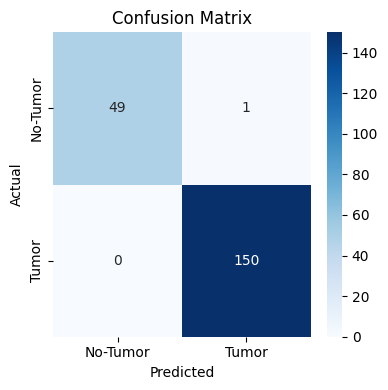

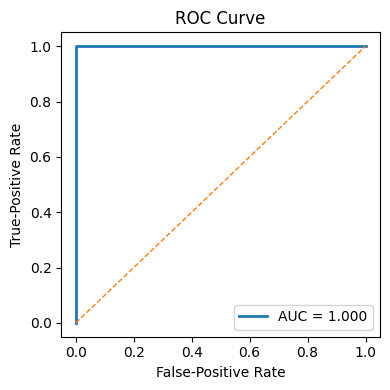

              precision    recall  f1-score   support

    No-Tumor       1.00      0.98      0.99        50
       Tumor       0.99      1.00      1.00       150

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No-Tumor','Tumor'], yticklabels=['No-Tumor','Tumor'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.tight_layout(); plt.savefig('/content/conf_matrix.png', dpi=300); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel('False-Positive Rate'); plt.ylabel('True-Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.tight_layout()
plt.savefig('/content/roc_curve.png', dpi=300); plt.show()

# Full metrics
print(classification_report(y_true, y_pred, target_names=['No-Tumor','Tumor']))


In [ ]:
# Example
if __name__=="__main__":
    test_path = '/content/drive/MyDrive/Brain Tumor/Dataset/Testing/No/Copy of Te-no_0348.jpg'
    print(predict_image(test_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
('No Tumor', np.float32(0.03371977))
